In [10]:
from estimador import *
from functions import *
from filtros import *
from fit_voc import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Obtenemos el Ground Truth de SOH y subciclos ejecutados por las celdas

In [53]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_SOH_25deg.csv"
gt_soh_values = pd.read_csv(gt_path)
# Obtenemos los ciclos de cada celda
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_cycles_25deg.csv"
cycle_values = pd.read_csv(path)
# Obtenemos los ciclos de cada celda por tanda de degradación
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cycles_table.csv"
cycle_table = pd.read_csv(path)

gt_soh_values = gt_soh_values[['D25_D30_0','D25_E30_0','D25_F30_0','D25_C85_70','D25_D85_70','D25_D100_85','D25_E100_85','D25_F100_85','D25_D100_0_drive','D25_E100_0_drive','D25_D100_0_','D25_E100_0_']]
gt_soh_values.columns =  cycle_values.columns
cycle_table = cycle_table[['D25_D30_0','D25_E30_0','D25_F30_0','D25_C85_70','D25_D85_70','D25_D100_85','D25_E100_85','D25_F100_85','D25_D100_0_drive','D25_E100_0_drive','D25_D100_0_','D25_E100_0_']]
cycle_table.columns =  cycle_values.columns

idx = 10
gt_soh_values = gt_soh_values[0:idx]
cycle_table = cycle_table[0:idx]
cycle_table

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,258,258,258,515,515,515,515,515,78,78,78,78
1,258,258,258,515,515,515,515,515,78,78,78,78
2,258,258,258,515,515,515,515,515,78,78,78,78
3,258,258,258,515,515,515,515,515,78,78,78,78
4,258,258,258,515,515,515,515,515,78,78,78,78
5,258,258,258,515,515,515,515,515,78,78,78,78
6,258,258,258,515,515,515,515,515,78,78,78,78
7,258,258,258,515,515,515,515,515,78,78,78,78
8,258,258,258,515,515,515,515,515,78,78,78,78
9,258,258,258,515,515,515,515,515,78,78,78,78


In [57]:
gt_soh_values

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.956672,0.945440,0.953341,0.978380,0.978223,0.985113,0.987026,0.984339,0.957386,0.952200,0.958063,0.957267
2,0.888100,0.880463,0.888987,0.969021,0.970280,0.965058,0.964104,0.964840,0.934058,0.935481,0.933245,0.934681
3,0.857320,0.851063,0.853256,0.960418,0.962952,0.946165,0.944715,0.946973,0.920934,0.922607,0.908312,0.910992
4,0.841922,0.835265,0.833843,0.953576,0.955763,0.927879,0.927477,0.930778,0.911324,0.912829,0.889487,0.895003
5,0.832690,0.825146,0.824182,0.947506,0.950879,0.913063,0.908689,0.917540,0.902280,0.903161,0.883462,0.886562
6,0.824490,0.814722,0.810584,0.941144,0.942437,0.884896,0.876411,0.896086,0.892396,0.893675,0.876218,0.878436
7,0.818153,0.801828,0.797390,0.937413,0.934023,0.887786,0.888055,0.898636,0.883509,0.884577,0.868952,0.871723
8,0.812961,0.796190,0.791492,0.930387,0.925096,0.857548,0.845812,0.885889,0.875958,0.876944,0.862589,0.865615
9,0.803136,0.781448,0.765043,0.928263,0.919983,0.854349,0.839055,0.881913,0.864434,0.866416,0.855277,0.858361


### Obtenemos el total de subciclos ejecutados al segmentar los diagnósticos 

In [54]:
cycle_table_df = pd.DataFrame()
for i,column in enumerate(cycle_table.columns):
    total_cycles = sum(cycle_table[column])
    cycle_table_df[column] = [total_cycles]
cycle_table_df

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,2580,2580,2580,5150,5150,5150,5150,5150,780,780,780,780


## Aplicamos el modelo de degradación a cada celda
### Definimos los modelos a utilizar

In [34]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    # Qmax=df.SoH.max(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=1171,
    # life_cycles=1170,
    # life_cycles=300,
    adapt_cell=True,
    degradation_percentage=0.8
)

f_adap = FiltrosAnidados()
f_adap.Q_inst = param.get("Qmax")
f_adap.fit_batt_model(param)
f_adap.modelo_th.fit_inverse()
f_adap.voc_thresh = 0.05
f_adap.voc_times = 47
f_adap.sigma_autonomia = 0.04
f_adap.sigma_capacidad = 0.001 * 5
f_adap.estim_kwargs = {"sigma_e": 0.00075}


if f_adap.modelo_th.parameters["adapt_cell"]:
    f_adap.modelo_th.adapt_degradation()
    f_adap.modelo_th.setup_knn()
    print("celda: f_adap_st adaptada")

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [1.00000266], '75-0': [1.0000186], '100-50': [0.99999203], '75-25': [1.00001521], '50-0': [1.00002874], '100-75': [1.00002146], '75-50': [1.00000881], '62.5-37.5': [1.0000062], '50-25': [1.00003347], '25-0': [1.00004184]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [1.00000266],
                      '100-50': [0.99999203],
                      '100-75': [1.00002146],
                      '25-0': [1.00004184],
                      '50-0': [1.00002874],
                      '50-25': [1.00003347],
                     

### Ejecutamos el modelo de degradación para cada celda

In [55]:
models = [f_adap]
models_str = ["f_adap"]
cells = list(cycle_values.columns)
SR = [[30,0],[30,0],[30,0],[85,70],[85,70],[100,85],[100,85],[100,85],[100,0],[100,0],[100,0],[100,0]]

cells_ = []
models_ = []
SR_ = []

for model in models:
    model.Q_inst = param.get("Qmax")

cells_SOH_list = [] #lista de listas de SOH de cada modelo por cada celda
models_SOH_list = [] #lista con SOH de cada modelo para cada celda

max_len = 0
Q_healthy = param.get("Qmax")
cell_eq_cycle = pd.DataFrame()
max_values = pd.DataFrame()

for i,cell in enumerate(cells):
    SOH_values = []
    eq_cycle_cnt = 0
    soc_inst = SR[i][0]
    soc_counting_eqcycle = [soc_inst]
    soc_acc = 0

    soc_profile = generate_soc_profile(SR[i][0],SR[i][1],cycle_table_df[cell].values[0])
    differences = [soc_profile[i] - soc_profile[i-1] for i in range(1, len(soc_profile))]

    for j,model in enumerate(models):
        for dsoc in differences:
            soc_inst += dsoc
            if dsoc < 0:
                soc_acc+=dsoc
                soc_counting_eqcycle.append(soc_inst)
            if soc_acc < -100:
                eta_k_eqcycle = model.get_factor(soc_counting_eqcycle,unnml=False)
                model.Q_inst *= eta_k_eqcycle[0]

                soc_acc = 0
                soc_counting_eqcycle = [soc_counting_eqcycle[-1]]
                eq_cycle_cnt += 1
            SOH_values.append(model.Q_inst / Q_healthy)
        
        max_len = len(SOH_values) #obtenemos la cantidad max de muestras por SR de cada celda
        max_values[cell] = [max_len] #se guarda para cada celda
        cell_eq_cycle[cell] = [eq_cycle_cnt]
        eq_cycle_cnt = 0

        models_SOH_list.append(SOH_values) #se guarda la degradación de cada celda
        SOH_values = []
        model.Q_inst = param.get("Qmax")

    cells_SOH_list.append(models_SOH_list)
    models_SOH_list = []
    



eta normal:  [0.99979074]  aplicado
eta normal:  [0.99979459]  aplicado
eta normal:  [0.99979519]  aplicado
eta normal:  [0.99979293]  aplicado
eta normal:  [0.99979511]  aplicado
eta normal:  [0.9997944]  aplicado
eta normal:  [0.99979359]  aplicado
eta normal:  [0.99979556]  aplicado
eta normal:  [0.99979349]  aplicado
eta normal:  [0.99979421]  aplicado
eta normal:  [0.99979563]  aplicado
eta normal:  [0.99979246]  aplicado
eta normal:  [0.99979477]  aplicado
eta normal:  [0.99979494]  aplicado
eta normal:  [0.99979316]  aplicado
eta normal:  [0.99979527]  aplicado
eta normal:  [0.99979411]  aplicado
eta normal:  [0.99979381]  aplicado
eta normal:  [0.99979569]  aplicado
eta normal:  [0.99979316]  aplicado
eta normal:  [0.9997944]  aplicado
eta normal:  [0.99979542]  aplicado
eta normal:  [0.9997927]  aplicado
eta normal:  [0.99979494]  aplicado
eta normal:  [0.99979468]  aplicado
eta normal:  [0.99979338]  aplicado
eta normal:  [0.99979542]  aplicado
eta normal:  [0.99979381]  apli

In [52]:
soh_test = pd.DataFrame()
for cell in cells:
    soh = gt_soh_values[cell].values[~np.isnan(gt_soh_values[cell].values)][-1]
    soh_test[cell] = [soh]
soh_test

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,0.83269,0.825146,0.824182,0.947506,0.950879,0.913063,0.908689,0.91754,0.90228,0.903161,0.883462,0.886562


### Ciclos equivalentes ejecutados para la segmentación actual 

In [50]:
cell_eq_cycle

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,459,459,459,458,458,458,458,458,463,463,463,463


### Ciclos equivalentes extrapolados a SOH = 80% 

In [45]:
cells = list(cycle_values.columns)
EQ_cycles = pd.DataFrame()
for cell in cells:
    eq_cycles = cell_eq_cycle[cell]
    soh = gt_soh_values[cell].values[~np.isnan(gt_soh_values[cell].values)][-1]
    eta_0 = soh**(1/eq_cycles)
    eq_cycles08 = eq_cycle08 = 1/log_a(0.8,eta_0)
    EQ_cycles[cell] = [int(eq_cycles08[0])]
EQ_cycles

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,779,693,638,2290,2044,1083,971,1356,1182,1201,1101,1127


### Obtenemos el df con los SOH calculados y rellenamos con nan

In [5]:
cells_SOH = pd.DataFrame()
lengths = []
for i,cell in enumerate(cells):
    lengths.append(max(len(list) for list in cells_SOH_list[i]))
max_length = max(lengths)

# Function to pad the list with NaN to match the maximum length
def pad_list(lst, length):
    return lst + [np.nan] * (length - len(lst))

for i,cell in enumerate(cells):
    for j,model in enumerate(models_str):
        str_ = str(cell)+str(model)
        cells_SOH[str_] = pad_list(cells_SOH_list[i][j], max_length)

### Adaptamos los indices del GT

In [6]:
indexes = []
indexes_df = pd.DataFrame()
for i,cell in enumerate(cells):
    count = gt_soh_values[cell].count()
    index_list = np.linspace(0, max_values[cell][0], count)
    indexes_ = [np.round(idx,0) for idx in index_list.tolist()]
    indexes.append(indexes_)

max_length = 16
for i,cell in enumerate(cells):
    indexes[i] = pad_list(indexes[i], max_length)
    indexes_df[cell] = indexes[i]
    
indexes_df

,D30_0,D85_70,D100_85,D100_0_drive,D100_0_
0,0.0,0.0,0.0,0.0,0.0
1,8015.0,8265.0,8257.0,7777.0,7878.0
2,16029.0,16530.0,16515.0,15554.0,15756.0
3,24044.0,24796.0,24772.0,23331.0,23634.0
4,32058.0,33061.0,33029.0,31108.0,31512.0
5,40073.0,41326.0,41287.0,38884.0,39390.0
6,48088.0,49592.0,49544.0,46661.0,47268.0
7,56102.0,57857.0,57802.0,54438.0,55146.0
8,64117.0,66122.0,66059.0,62215.0,63023.0
9,72132.0,74387.0,74316.0,69992.0,70901.0


### Graficamos los valores

In [ ]:
for i, cell in enumerate(cells):
    plt.figure(figsize=(20, 6))
    plt.plot(indexes_df[cell], gt_soh_values[cell], label="GT", marker = 'o')
    for j,model in enumerate(models_str):
        str_ = str(cell)+str(model)
        plt.plot(cells_SOH[str_].values, label=str_)
    plt.xlabel('Index')
    plt.ylabel('SOH')
    plt.title(cell)
    # plt.ylim((0.75, 1))
    plt.legend()
    plt.show()

### Generamos el MAE de cada modelo

In [8]:
model_errors = pd.DataFrame()
errors = pd.DataFrame()
errors["Casos"] = cells

for i, cell in enumerate(cells):
    for j,model in enumerate(models_str):
        str_ = str(cell)+str(model)

        idx_gt = gt_soh_values[cell].last_valid_index()
        idx = cells_SOH[str_].last_valid_index()

        gt = gt_soh_values[cell][idx_gt]
        value = cells_SOH[str_][idx]

        error = np.round(abs(gt - value)*100,2)
        model_errors[str_] = [error]

lst = []
for j,model in enumerate(models_str):
    for i,cell in enumerate(cells):
        str_ = str(cell)+str(model)
        lst.append(model_errors[str_][0])
    errors[model] = lst
    lst = []

errors

,Casos,f_adap
0,D30_0,4.47
1,D85_70,32.16
2,D100_85,20.08
3,D100_0_drive,1.23
4,D100_0_,0.95


In [10]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

# Apply the highlight_min function across the rows (axis=1)
st_errors_style = errors.style.apply(highlight_min, axis=1, subset=pd.IndexSlice[:, 'f_aramis_ds':'f_lin_ag'])

# Display the styled DataFrame
st_errors_style

,Casos,f_adap
0,D30_0,1.240000
1,D85_70,42.240000
2,D100_85,29.200000
3,D100_0_drive,2.760000
4,D100_0_,7.010000


In [11]:
st_errors = errors[["Casos","f_adap_ds","f_adap_st","f_adap_ag","f_lin_ds","f_lin_st","f_lin_ag"]]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

# Apply the highlight_min function across the rows (axis=1)
st_errors_style = st_errors.style.apply(highlight_min, axis=1, subset=pd.IndexSlice[:, 'f_adap_ds':'f_lin_ag'])

# Display the styled DataFrame
st_errors_style

KeyError: "['f_adap_ds', 'f_adap_st', 'f_adap_ag', 'f_lin_ds', 'f_lin_st', 'f_lin_ag'] not in index"

In [ ]:
st_errors = errors[["Casos","f_aramis_st","f_adap_st","f_lin_st"]]
st_errors

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

# Apply the highlight_min function across the rows (axis=1)
st_errors_style = st_errors.style.apply(highlight_min, axis=1, subset=pd.IndexSlice[:, 'f_aramis_st':'f_lin_st'])

# Display the styled DataFrame
st_errors_style

,Casos,f_aramis_st,f_adap_st,f_lin_st
0,D30_0,0.050000,0.010000,0.020000
1,D85_70,0.100000,0.210000,0.110000
2,D100_85,0.030000,0.180000,0.040000
3,D100_0_drive,0.000000,0.010000,0.020000
4,D100_0_,0.020000,0.040000,0.050000


In [ ]:
st_errors = errors[["Casos","f_adap_st","f_lin_st"]]
st_errors

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

# Apply the highlight_min function across the rows (axis=1)
st_errors_style = st_errors.style.apply(highlight_min, axis=1, subset=pd.IndexSlice[:, 'f_adap_st':'f_lin_st'])

# Display the styled DataFrame
st_errors_style

,Casos,f_adap_st,f_lin_st
0,D30_0,0.010000,0.020000
1,D85_70,0.210000,0.110000
2,D100_85,0.180000,0.040000
3,D100_0_drive,0.010000,0.020000
4,D100_0_,0.040000,0.050000


In [65]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_SOH_25deg.csv"
gt_soh_values = pd.read_csv(gt_path)
# Obtenemos los ciclos de cada celda
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_cycles_25deg.csv"
cycle_values = pd.read_csv(path)
# Obtenemos los ciclos de cada celda por tanda de degradación
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cycles_table.csv"
cycle_table = pd.read_csv(path)

gt_soh_values = gt_soh_values[['D25_D30_0','D25_E30_0','D25_F30_0','D25_C85_70','D25_D85_70','D25_D100_85','D25_E100_85','D25_F100_85','D25_D100_0_drive','D25_E100_0_drive','D25_D100_0_','D25_E100_0_']]
gt_soh_values.columns =  cycle_values.columns
cycle_table = cycle_table[['D25_D30_0','D25_E30_0','D25_F30_0','D25_C85_70','D25_D85_70','D25_D100_85','D25_E100_85','D25_F100_85','D25_D100_0_drive','D25_E100_0_drive','D25_D100_0_','D25_E100_0_']]
cycle_table.columns =  cycle_values.columns

total_EQ_cycles = pd.DataFrame(columns=cycle_values.columns)

idx = 2
while idx < 10: 

    gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_SOH_25deg.csv"
    gt_soh_values = pd.read_csv(gt_path)
    # Obtenemos los ciclos de cada celda
    path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_cycles_25deg.csv"
    cycle_values = pd.read_csv(path)
    # Obtenemos los ciclos de cada celda por tanda de degradación
    path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cycles_table.csv"
    cycle_table = pd.read_csv(path)

    gt_soh_values = gt_soh_values[['D25_D30_0','D25_E30_0','D25_F30_0','D25_C85_70','D25_D85_70','D25_D100_85','D25_E100_85','D25_F100_85','D25_D100_0_drive','D25_E100_0_drive','D25_D100_0_','D25_E100_0_']]
    gt_soh_values.columns =  cycle_values.columns
    cycle_table = cycle_table[['D25_D30_0','D25_E30_0','D25_F30_0','D25_C85_70','D25_D85_70','D25_D100_85','D25_E100_85','D25_F100_85','D25_D100_0_drive','D25_E100_0_drive','D25_D100_0_','D25_E100_0_']]
    cycle_table.columns =  cycle_values.columns

    gt_soh_values = gt_soh_values[0:idx]
    cycle_table = cycle_table[0:idx-1]


    cycle_table_df = pd.DataFrame()
    for i,column in enumerate(cycle_table.columns):
        total_cycles = sum(cycle_table[column])
        cycle_table_df[column] = [total_cycles]

    models = [f_adap]
    models_str = ["f_adap"]
    cells = list(cycle_values.columns)
    SR = [[30,0],[30,0],[30,0],[85,70],[85,70],[100,85],[100,85],[100,85],[100,0],[100,0],[100,0],[100,0]]

    cells_ = []
    models_ = []
    SR_ = []

    for model in models:
        model.Q_inst = param.get("Qmax")

    cells_SOH_list = [] #lista de listas de SOH de cada modelo por cada celda
    models_SOH_list = [] #lista con SOH de cada modelo para cada celda

    max_len = 0
    Q_healthy = param.get("Qmax")
    cell_eq_cycle = pd.DataFrame()
    max_values = pd.DataFrame()

    for i,cell in enumerate(cells):
        SOH_values = []
        eq_cycle_cnt = 0
        soc_inst = SR[i][0]
        soc_counting_eqcycle = [soc_inst]
        soc_acc = 0

        soc_profile = generate_soc_profile(SR[i][0],SR[i][1],cycle_table_df[cell].values[0])
        differences = [soc_profile[i] - soc_profile[i-1] for i in range(1, len(soc_profile))]

        for j,model in enumerate(models):
            for dsoc in differences:
                soc_inst += dsoc
                if dsoc < 0:
                    soc_acc+=dsoc
                    soc_counting_eqcycle.append(soc_inst)
                if soc_acc < -100:
                    eta_k_eqcycle = model.get_factor(soc_counting_eqcycle,unnml=False)
                    model.Q_inst *= eta_k_eqcycle[0]

                    soc_acc = 0
                    soc_counting_eqcycle = [soc_counting_eqcycle[-1]]
                    eq_cycle_cnt += 1
                SOH_values.append(model.Q_inst / Q_healthy)
            
            max_len = len(SOH_values) #obtenemos la cantidad max de muestras por SR de cada celda
            max_values[cell] = [max_len] #se guarda para cada celda
            cell_eq_cycle[cell] = [eq_cycle_cnt]
            eq_cycle_cnt = 0

            models_SOH_list.append(SOH_values) #se guarda la degradación de cada celda
            SOH_values = []
            model.Q_inst = param.get("Qmax")

        cells_SOH_list.append(models_SOH_list)
        models_SOH_list = []

    cells = list(cycle_values.columns)
    EQ_cycles = pd.DataFrame()
    for cell in cells:
        eq_cycles = cell_eq_cycle[cell]
        soh = gt_soh_values[cell].values[~np.isnan(gt_soh_values[cell].values)][-1]
        eta_0 = soh**(1/eq_cycles)
        eq_cycles08 = eq_cycle08 = 1/log_a(0.8,eta_0)
        EQ_cycles[cell] = [int(eq_cycles08[0])]

    total_EQ_cycles = pd.concat([total_EQ_cycles, EQ_cycles], ignore_index=True)
    idx += 1

total_EQ_cycles

eta normal:  [0.99979074]  aplicado
eta normal:  [0.99979459]  aplicado
eta normal:  [0.99979519]  aplicado
eta normal:  [0.99979293]  aplicado
eta normal:  [0.99979511]  aplicado
eta normal:  [0.9997944]  aplicado
eta normal:  [0.99979359]  aplicado
eta normal:  [0.99979556]  aplicado
eta normal:  [0.99979349]  aplicado
eta normal:  [0.99979421]  aplicado
eta normal:  [0.99979563]  aplicado
eta normal:  [0.99979246]  aplicado
eta normal:  [0.99979477]  aplicado
eta normal:  [0.99979494]  aplicado
eta normal:  [0.99979316]  aplicado
eta normal:  [0.99979527]  aplicado
eta normal:  [0.99979411]  aplicado
eta normal:  [0.99979381]  aplicado
eta normal:  [0.99979569]  aplicado
eta normal:  [0.99979316]  aplicado
eta normal:  [0.9997944]  aplicado
eta normal:  [0.99979542]  aplicado
eta normal:  [0.9997927]  aplicado
eta normal:  [0.99979494]  aplicado
eta normal:  [0.99979468]  aplicado
eta normal:  [0.99979338]  aplicado
eta normal:  [0.99979542]  aplicado
eta normal:  [0.99979381]  apli

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,382,302,354,775,770,1130,1298,1074,394,350,401,393
1,287,268,290,1077,1124,953,927,947,503,515,497,508
2,331,316,322,1265,1353,923,898,937,625,639,536,552
3,396,379,375,1431,1504,909,903,948,740,753,586,619
4,466,444,441,1580,1692,937,890,990,837,845,695,715
5,530,499,487,1684,1723,835,774,931,907,919,781,797
6,595,541,528,1847,1749,1003,1005,1116,972,982,857,877
7,660,600,584,1889,1751,887,814,1125,1039,1048,931,954


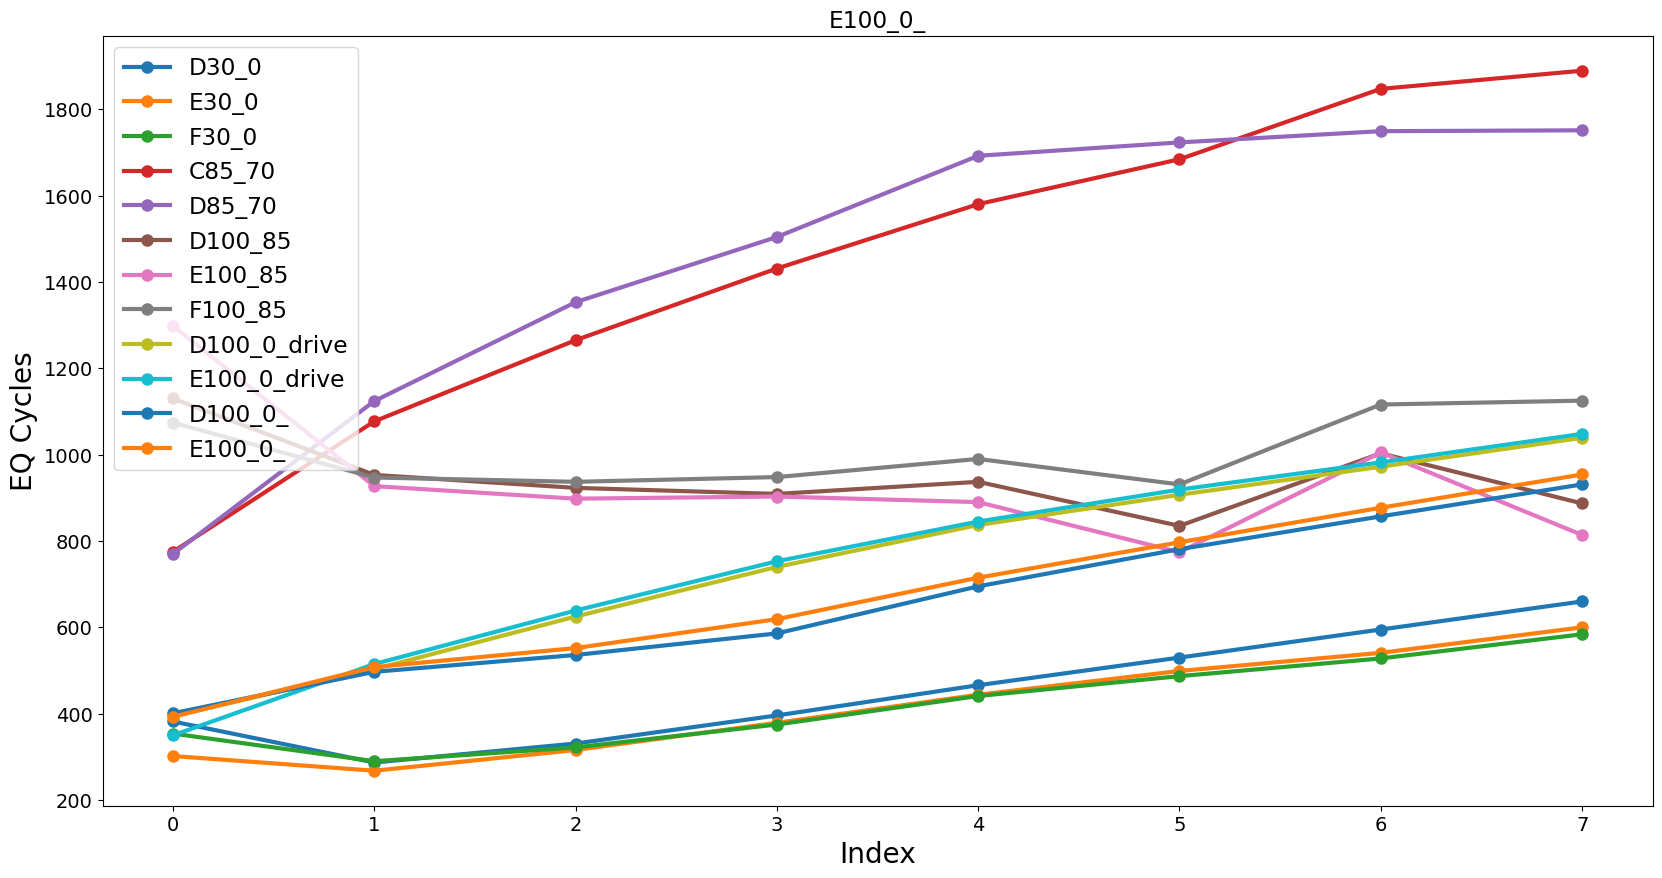

In [69]:

plt.figure(figsize=(20, 10))
for i, column in enumerate(total_EQ_cycles.columns):
    plt.plot(total_EQ_cycles[column], label=column, marker = 'o')
plt.xlabel('Index')
plt.ylabel('EQ Cycles')
plt.title(column)
# plt.ylim((0.75, 1))
plt.legend()
plt.show()